# Architektur Neuronales Netz

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            #nn.LayerNorm(hidden1_size),
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            #nn.LayerNorm(hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            #nn.LayerNorm(hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 1)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=200, bias=True)
    (2): Tanh()
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): Tanh()
    (5): Linear(in_features=200, out_features=200, bias=True)
    (6): Tanh()
    (7): Linear(in_features=200, out_features=1, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 128 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs xi
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
xi = torch.tensor(res['xi'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = xi.reshape((-1,1))
#print(x_input.size())
# print(xi.size())

# #Normalisieren der Tensoren
# x_input = norm(x_input, p=1, dim = 1)
# y_output = norm(y_output, p=1, dim = 0)

# Tensoren zu einem großen Set gruppieren
dataset = TensorDataset(x_input, y_output)

# for x,y in dataset:
#     print(x)
#     print(y)
    
# Split in Trainings und Test Set
train_dataset, test_dataset = random_split(dataset, 
                                           [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
                                           generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 1)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-3
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred, y)

            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if pred[i] - y[i] <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f} \n")

    net.train()
    
    return acc, loss, MRE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)

Epoch 1/200, Iteration 1/6, Loss: 0.1072
Epoch 1/200, Iteration 2/6, Loss: 1.7060
Epoch 1/200, Iteration 3/6, Loss: 2.9619
Epoch 1/200, Iteration 4/6, Loss: 2.1952
Epoch 1/200, Iteration 5/6, Loss: 0.9315
Epoch 1/200, Iteration 6/6, Loss: 0.3126
Epoch 1/200, Iteration 7/6, Loss: 0.6751
Train Error: 
 Accuracy: 0.0%, Avg loss: 0.928822, MRE: 52.976215 

Test Error: 
 Accuracy: 0.0%, Avg loss: 0.936561, MRE: 108.048856 

Epoch 2/200, Iteration 1/6, Loss: 0.6276
Epoch 2/200, Iteration 2/6, Loss: 0.4080
Epoch 2/200, Iteration 3/6, Loss: 0.3000
Epoch 2/200, Iteration 4/6, Loss: 0.3531
Epoch 2/200, Iteration 5/6, Loss: 0.3522
Epoch 2/200, Iteration 6/6, Loss: 0.2818
Epoch 2/200, Iteration 7/6, Loss: 0.1788
Train Error: 
 Accuracy: 32.88%, Avg loss: 0.150667, MRE: 5.578953 

Test Error: 
 Accuracy: 28.0%, Avg loss: 0.158894, MRE: 13.885648 

Epoch 3/200, Iteration 1/6, Loss: 0.1778
Epoch 3/200, Iteration 2/6, Loss: 0.1417
Epoch 3/200, Iteration 3/6, Loss: 0.1968
Epoch 3/200, Iteration 4/6, Lo

Epoch 20/200, Iteration 5/6, Loss: 0.0550
Epoch 20/200, Iteration 6/6, Loss: 0.0632
Epoch 20/200, Iteration 7/6, Loss: 0.0613
Train Error: 
 Accuracy: 27.75%, Avg loss: 0.068171, MRE: 4.211091 

Test Error: 
 Accuracy: 21.5%, Avg loss: 0.070709, MRE: 10.036653 

Epoch 21/200, Iteration 1/6, Loss: 0.0737
Epoch 21/200, Iteration 2/6, Loss: 0.0668
Epoch 21/200, Iteration 3/6, Loss: 0.0618
Epoch 21/200, Iteration 4/6, Loss: 0.0668
Epoch 21/200, Iteration 5/6, Loss: 0.0376
Epoch 21/200, Iteration 6/6, Loss: 0.0429
Epoch 21/200, Iteration 7/6, Loss: 0.0245
Train Error: 
 Accuracy: 68.62%, Avg loss: 0.038760, MRE: 2.299081 

Test Error: 
 Accuracy: 77.0%, Avg loss: 0.037839, MRE: 5.754184 

Epoch 22/200, Iteration 1/6, Loss: 0.0378
Epoch 22/200, Iteration 2/6, Loss: 0.0315
Epoch 22/200, Iteration 3/6, Loss: 0.0322
Epoch 22/200, Iteration 4/6, Loss: 0.0385
Epoch 22/200, Iteration 5/6, Loss: 0.0257
Epoch 22/200, Iteration 6/6, Loss: 0.0338
Epoch 22/200, Iteration 7/6, Loss: 0.0476
Train Error: 

Train Error: 
 Accuracy: 83.88%, Avg loss: 0.008690, MRE: 0.561457 

Test Error: 
 Accuracy: 86.5%, Avg loss: 0.008655, MRE: 1.355532 

Epoch 40/200, Iteration 1/6, Loss: 0.0097
Epoch 40/200, Iteration 2/6, Loss: 0.0150
Epoch 40/200, Iteration 3/6, Loss: 0.0121
Epoch 40/200, Iteration 4/6, Loss: 0.0105
Epoch 40/200, Iteration 5/6, Loss: 0.0083
Epoch 40/200, Iteration 6/6, Loss: 0.0081
Epoch 40/200, Iteration 7/6, Loss: 0.0091
Train Error: 
 Accuracy: 69.25%, Avg loss: 0.009622, MRE: 0.644235 

Test Error: 
 Accuracy: 70.5%, Avg loss: 0.009931, MRE: 0.966129 

Epoch 41/200, Iteration 1/6, Loss: 0.0133
Epoch 41/200, Iteration 2/6, Loss: 0.0128
Epoch 41/200, Iteration 3/6, Loss: 0.0080
Epoch 41/200, Iteration 4/6, Loss: 0.0100
Epoch 41/200, Iteration 5/6, Loss: 0.0084
Epoch 41/200, Iteration 6/6, Loss: 0.0076
Epoch 41/200, Iteration 7/6, Loss: 0.0236
Train Error: 
 Accuracy: 92.5%, Avg loss: 0.008083, MRE: 0.481970 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.009006, MRE: 1.518299 

Epoch

Train Error: 
 Accuracy: 91.38%, Avg loss: 0.004913, MRE: 0.325311 

Test Error: 
 Accuracy: 90.0%, Avg loss: 0.005442, MRE: 1.123143 

Epoch 60/200, Iteration 1/6, Loss: 0.0088
Epoch 60/200, Iteration 2/6, Loss: 0.0053
Epoch 60/200, Iteration 3/6, Loss: 0.0138
Epoch 60/200, Iteration 4/6, Loss: 0.0076
Epoch 60/200, Iteration 5/6, Loss: 0.0141
Epoch 60/200, Iteration 6/6, Loss: 0.0082
Epoch 60/200, Iteration 7/6, Loss: 0.0112
Train Error: 
 Accuracy: 92.88%, Avg loss: 0.004955, MRE: 0.354614 

Test Error: 
 Accuracy: 90.5%, Avg loss: 0.005114, MRE: 0.766478 

Epoch 61/200, Iteration 1/6, Loss: 0.0070
Epoch 61/200, Iteration 2/6, Loss: 0.0097
Epoch 61/200, Iteration 3/6, Loss: 0.0086
Epoch 61/200, Iteration 4/6, Loss: 0.0039
Epoch 61/200, Iteration 5/6, Loss: 0.0080
Epoch 61/200, Iteration 6/6, Loss: 0.0100
Epoch 61/200, Iteration 7/6, Loss: 0.0104
Train Error: 
 Accuracy: 95.5%, Avg loss: 0.004311, MRE: 0.296959 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.004646, MRE: 1.095762 

Epoch

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.005044, MRE: 1.125686 

Epoch 80/200, Iteration 1/6, Loss: 0.0061
Epoch 80/200, Iteration 2/6, Loss: 0.0101
Epoch 80/200, Iteration 3/6, Loss: 0.0063
Epoch 80/200, Iteration 4/6, Loss: 0.0076
Epoch 80/200, Iteration 5/6, Loss: 0.0071
Epoch 80/200, Iteration 6/6, Loss: 0.0042
Epoch 80/200, Iteration 7/6, Loss: 0.0052
Train Error: 
 Accuracy: 97.25%, Avg loss: 0.003915, MRE: 0.291671 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.004421, MRE: 1.034229 

Epoch 81/200, Iteration 1/6, Loss: 0.0052
Epoch 81/200, Iteration 2/6, Loss: 0.0063
Epoch 81/200, Iteration 3/6, Loss: 0.0058
Epoch 81/200, Iteration 4/6, Loss: 0.0050
Epoch 81/200, Iteration 5/6, Loss: 0.0110
Epoch 81/200, Iteration 6/6, Loss: 0.0114
Epoch 81/200, Iteration 7/6, Loss: 0.0079
Train Error: 
 Accuracy: 94.0%, Avg loss: 0.004590, MRE: 0.419157 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.004824, MRE: 0.691689 

Epoch 82/200, Iteration 1/6, Loss: 0.0078
Epoch 82/200, Iteration 2/6, Los

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.004076, MRE: 0.906978 

Epoch 100/200, Iteration 1/6, Loss: 0.0068
Epoch 100/200, Iteration 2/6, Loss: 0.0076
Epoch 100/200, Iteration 3/6, Loss: 0.0218
Epoch 100/200, Iteration 4/6, Loss: 0.0057
Epoch 100/200, Iteration 5/6, Loss: 0.0080
Epoch 100/200, Iteration 6/6, Loss: 0.0059
Epoch 100/200, Iteration 7/6, Loss: 0.0157
Train Error: 
 Accuracy: 96.5%, Avg loss: 0.003945, MRE: 0.321308 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.004733, MRE: 0.886340 

Epoch 101/200, Iteration 1/6, Loss: 0.0042
Epoch 101/200, Iteration 2/6, Loss: 0.0054
Epoch 101/200, Iteration 3/6, Loss: 0.0051
Epoch 101/200, Iteration 4/6, Loss: 0.0057
Epoch 101/200, Iteration 5/6, Loss: 0.0060
Epoch 101/200, Iteration 6/6, Loss: 0.0141
Epoch 101/200, Iteration 7/6, Loss: 0.0113
Train Error: 
 Accuracy: 95.0%, Avg loss: 0.003989, MRE: 0.269220 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.004302, MRE: 0.778384 

Epoch 102/200, Iteration 1/6, Loss: 0.0095
Epoch 102/200, Ite

Epoch 119/200, Iteration 1/6, Loss: 0.0065
Epoch 119/200, Iteration 2/6, Loss: 0.0065
Epoch 119/200, Iteration 3/6, Loss: 0.0067
Epoch 119/200, Iteration 4/6, Loss: 0.0054
Epoch 119/200, Iteration 5/6, Loss: 0.0057
Epoch 119/200, Iteration 6/6, Loss: 0.0045
Epoch 119/200, Iteration 7/6, Loss: 0.0108
Train Error: 
 Accuracy: 95.12%, Avg loss: 0.003999, MRE: 0.284326 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.004456, MRE: 0.717787 

Epoch 120/200, Iteration 1/6, Loss: 0.0055
Epoch 120/200, Iteration 2/6, Loss: 0.0049
Epoch 120/200, Iteration 3/6, Loss: 0.0048
Epoch 120/200, Iteration 4/6, Loss: 0.0072
Epoch 120/200, Iteration 5/6, Loss: 0.0096
Epoch 120/200, Iteration 6/6, Loss: 0.0056
Epoch 120/200, Iteration 7/6, Loss: 0.0346
Train Error: 
 Accuracy: 93.25%, Avg loss: 0.004711, MRE: 0.309578 

Test Error: 
 Accuracy: 90.5%, Avg loss: 0.005207, MRE: 0.786222 

Epoch 121/200, Iteration 1/6, Loss: 0.0047
Epoch 121/200, Iteration 2/6, Loss: 0.0047
Epoch 121/200, Iteration 3/6, Loss: 0.00

Epoch 138/200, Iteration 4/6, Loss: 0.0139
Epoch 138/200, Iteration 5/6, Loss: 0.0049
Epoch 138/200, Iteration 6/6, Loss: 0.0067
Epoch 138/200, Iteration 7/6, Loss: 0.0130
Train Error: 
 Accuracy: 96.38%, Avg loss: 0.003548, MRE: 0.251773 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.004224, MRE: 0.874743 

Epoch 139/200, Iteration 1/6, Loss: 0.0036
Epoch 139/200, Iteration 2/6, Loss: 0.0080
Epoch 139/200, Iteration 3/6, Loss: 0.0049
Epoch 139/200, Iteration 4/6, Loss: 0.0039
Epoch 139/200, Iteration 5/6, Loss: 0.0045
Epoch 139/200, Iteration 6/6, Loss: 0.0062
Epoch 139/200, Iteration 7/6, Loss: 0.0085
Train Error: 
 Accuracy: 96.75%, Avg loss: 0.003464, MRE: 0.253731 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.004059, MRE: 0.962305 

Epoch 140/200, Iteration 1/6, Loss: 0.0070
Epoch 140/200, Iteration 2/6, Loss: 0.0070
Epoch 140/200, Iteration 3/6, Loss: 0.0063
Epoch 140/200, Iteration 4/6, Loss: 0.0081
Epoch 140/200, Iteration 5/6, Loss: 0.0125
Epoch 140/200, Iteration 6/6, Loss: 0.00

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.004306, MRE: 0.979428 

Epoch 158/200, Iteration 1/6, Loss: 0.0035
Epoch 158/200, Iteration 2/6, Loss: 0.0049
Epoch 158/200, Iteration 3/6, Loss: 0.0088
Epoch 158/200, Iteration 4/6, Loss: 0.0053
Epoch 158/200, Iteration 5/6, Loss: 0.0125
Epoch 158/200, Iteration 6/6, Loss: 0.0077
Epoch 158/200, Iteration 7/6, Loss: 0.0208
Train Error: 
 Accuracy: 96.38%, Avg loss: 0.003615, MRE: 0.270043 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.004070, MRE: 0.790263 

Epoch 159/200, Iteration 1/6, Loss: 0.0080
Epoch 159/200, Iteration 2/6, Loss: 0.0061
Epoch 159/200, Iteration 3/6, Loss: 0.0158
Epoch 159/200, Iteration 4/6, Loss: 0.0050
Epoch 159/200, Iteration 5/6, Loss: 0.0092
Epoch 159/200, Iteration 6/6, Loss: 0.0058
Epoch 159/200, Iteration 7/6, Loss: 0.0153
Train Error: 
 Accuracy: 96.62%, Avg loss: 0.003661, MRE: 0.458490 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.004149, MRE: 0.725173 

Epoch 160/200, Iteration 1/6, Loss: 0.0049
Epoch 160/200, I

Train Error: 
 Accuracy: 98.25%, Avg loss: 0.004480, MRE: 0.304069 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.005047, MRE: 1.049652 

Epoch 178/200, Iteration 1/6, Loss: 0.0111
Epoch 178/200, Iteration 2/6, Loss: 0.0052
Epoch 178/200, Iteration 3/6, Loss: 0.0093
Epoch 178/200, Iteration 4/6, Loss: 0.0128
Epoch 178/200, Iteration 5/6, Loss: 0.0100
Epoch 178/200, Iteration 6/6, Loss: 0.0097
Epoch 178/200, Iteration 7/6, Loss: 0.0092
Train Error: 
 Accuracy: 98.25%, Avg loss: 0.004014, MRE: 0.293546 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.004463, MRE: 0.941864 

Epoch 179/200, Iteration 1/6, Loss: 0.0045
Epoch 179/200, Iteration 2/6, Loss: 0.0060
Epoch 179/200, Iteration 3/6, Loss: 0.0056
Epoch 179/200, Iteration 4/6, Loss: 0.0074
Epoch 179/200, Iteration 5/6, Loss: 0.0105
Epoch 179/200, Iteration 6/6, Loss: 0.0072
Epoch 179/200, Iteration 7/6, Loss: 0.0110
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.003723, MRE: 0.262140 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.004285, MRE: 0

Train Error: 
 Accuracy: 98.12%, Avg loss: 0.003902, MRE: 0.283444 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.004425, MRE: 1.085541 

Epoch 197/200, Iteration 1/6, Loss: 0.0063
Epoch 197/200, Iteration 2/6, Loss: 0.0076
Epoch 197/200, Iteration 3/6, Loss: 0.0050
Epoch 197/200, Iteration 4/6, Loss: 0.0082
Epoch 197/200, Iteration 5/6, Loss: 0.0096
Epoch 197/200, Iteration 6/6, Loss: 0.0076
Epoch 197/200, Iteration 7/6, Loss: 0.0123
Train Error: 
 Accuracy: 97.0%, Avg loss: 0.003511, MRE: 0.258674 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.003824, MRE: 0.891284 

Epoch 198/200, Iteration 1/6, Loss: 0.0084
Epoch 198/200, Iteration 2/6, Loss: 0.0061
Epoch 198/200, Iteration 3/6, Loss: 0.0038
Epoch 198/200, Iteration 4/6, Loss: 0.0084
Epoch 198/200, Iteration 5/6, Loss: 0.0051
Epoch 198/200, Iteration 6/6, Loss: 0.0086
Epoch 198/200, Iteration 7/6, Loss: 0.0117
Train Error: 
 Accuracy: 97.25%, Avg loss: 0.003494, MRE: 0.251295 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.003989, MRE: 1.

#### Plots loss vs Epoch

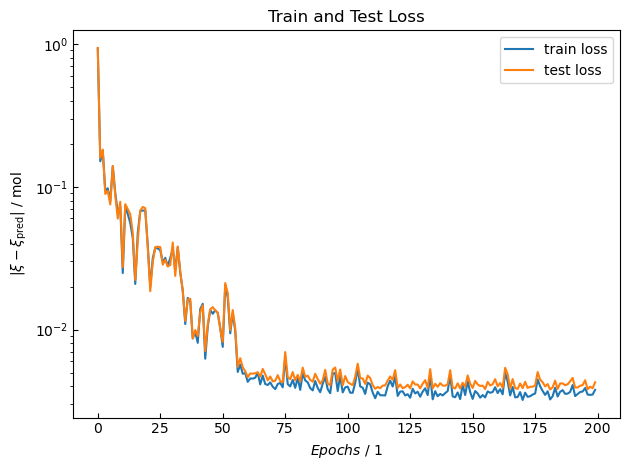

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2 = 0.9933621919763916
Test Dataset: R^2 = 0.9788438337136647
Max Error Training: |xi - xi_pred| = 0.03793436184098989
Max Error Test: |xi - xi_pred| = 0.03639965898167889


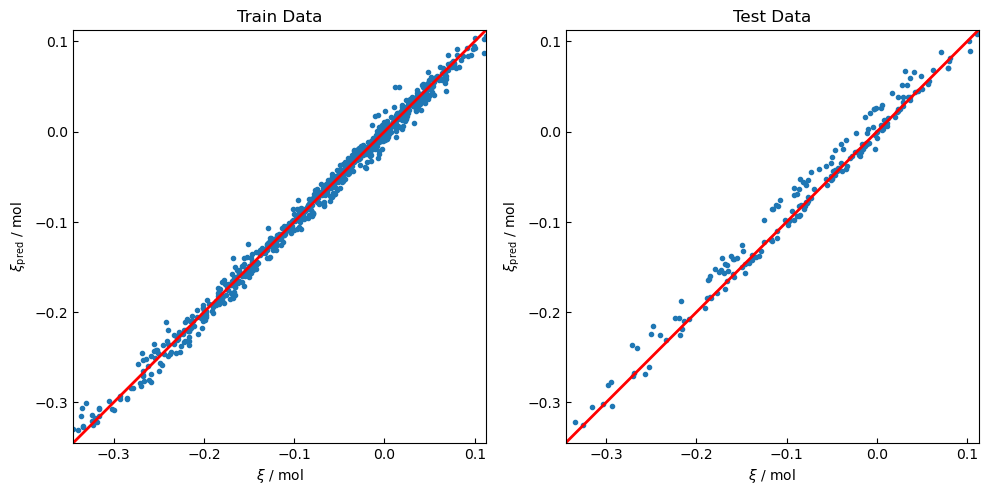

In [11]:
xi_real = []
xi_pred = []
for (X,y) in train_dataloader:
    xi_real = np.append(xi_real, y.numpy())
    xi_pred = np.append(xi_pred, net(X).detach().numpy())

xi_real_test = []
xi_pred_test = []
for (X,y) in test_dataloader:
    xi_real_test = np.append(xi_real_test, y.numpy())
    xi_pred_test = np.append(xi_pred_test, net(X).detach().numpy())

print('Training Dataset: R^2 =', r2(xi_real,xi_pred))
print('Test Dataset: R^2 =', r2(xi_real_test,xi_pred_test))
print('Max Error Training: |xi - xi_pred| =', max_error(xi_real, xi_pred))
print('Max Error Test: |xi - xi_pred| =', max_error(xi_real_test, xi_pred_test))

# find the boundaries of X and Y values
bounds = (min(xi_real.min(), xi_pred.min()) - int(0.1 * xi_pred.min()), max(xi_real.max(), xi_pred.max())+ int(0.1 * xi_pred.max()))

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(xi_real, xi_pred, '.')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(xi_real_test, xi_pred_test, '.')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

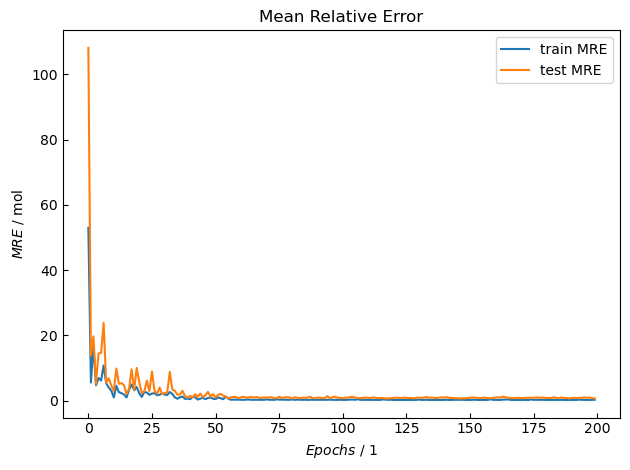

In [12]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_MRE, label='train MRE')
ax.plot(test_MRE, label='test MRE')
plt.title("Mean Relative Error")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

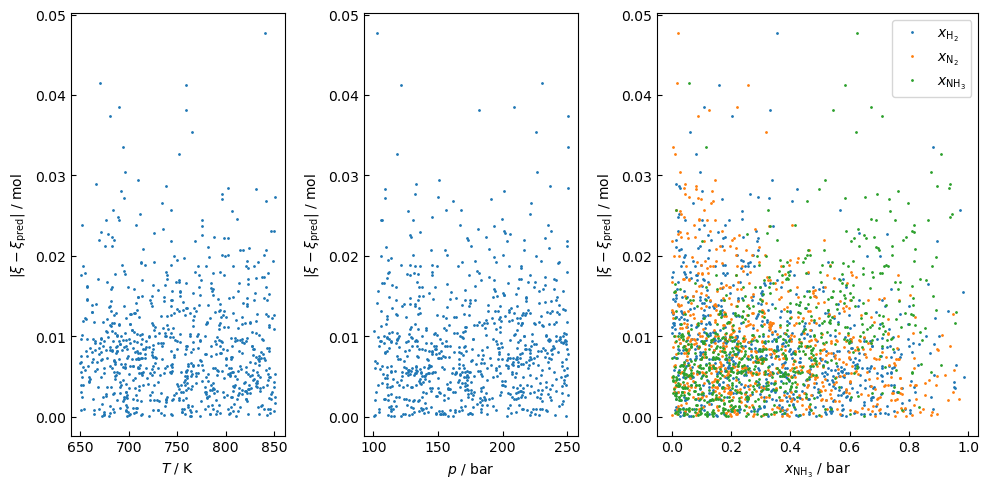

In [13]:
mistake = []
param_T = []
param_p = []
param_x_H2 = []
param_x_N2 = []
param_x_NH3 = []
for X,y in train_dataloader:
    mistake = np.append(mistake, abs(y - net(X).detach().numpy()))
    param_T = np.append(param_T, X[:,0])
    param_p = np.append(param_p, X[:,1])
    param_x_H2 = np.append(param_x_H2, X[:,2])
    param_x_N2 = np.append(param_x_N2, X[:,3])
    param_x_NH3 = np.append(param_x_NH3, X[:,4])
    
# train_parameters, train_xi = next(iter(train_dataloader))
# y = abs(train_xi - net(train_parameters).detach().numpy())
# #[T, p ,x_H2, x_N2, x_NH3]
# x = [train_parameters[:,0], train_parameters[:,1], train_parameters[:,2], train_parameters[:,3], train_parameters[:,4]]

# print(param_T[0])
# print(param_T)
# print(mistake)

fig,ax = plt.subplots(1,3, figsize = (10, 5), gridspec_kw={'width_ratios': [2,2,3]})

ax[0].plot(param_T, mistake, '.', markersize = 2)
ax[0].set(xlabel = '$T$ / K', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)

ax[1].plot(param_p, mistake, '.', markersize = 2)
ax[1].set(xlabel = '$p$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)

ax[2].plot(param_x_H2, mistake, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[2].plot(param_x_N2, mistake, '.', markersize = 2, label = '$x\mathregular{_{N_2}}$')
ax[2].plot(param_x_NH3, mistake, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[2].set(xlabel = '$x\mathregular{_{NH_3}}$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[2].tick_params(direction = 'in') #, length = 20, width = 3)
ax[2].set

plt.legend()
plt.tight_layout()
plt.show()

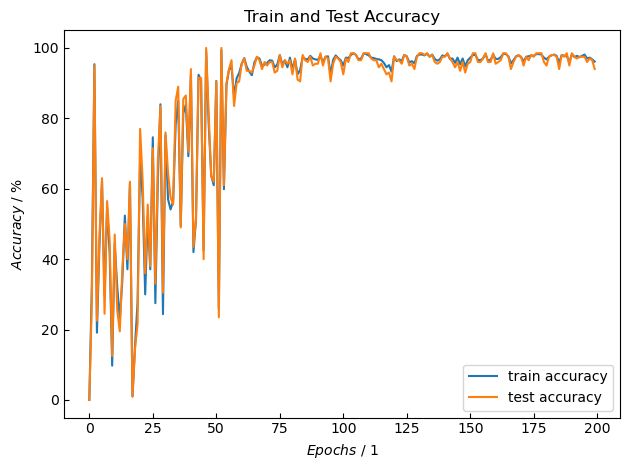

In [14]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [15]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y.reshape((-1,1)))
    print(net(X))
    break

tensor([[8.3689e+02, 1.1214e+02, 6.6677e-02, 1.9192e-01, 7.4140e-01],
        [6.6423e+02, 1.5395e+02, 4.6340e-01, 4.4111e-01, 9.5490e-02],
        [7.2460e+02, 1.8371e+02, 7.2535e-03, 1.7312e-01, 8.1963e-01],
        [7.2320e+02, 1.0303e+02, 1.0689e-01, 4.9444e-01, 3.9868e-01],
        [6.6310e+02, 1.7660e+02, 4.5854e-01, 4.0436e-01, 1.3710e-01],
        [7.1206e+02, 2.2070e+02, 1.7358e-01, 7.3171e-01, 9.4707e-02],
        [8.3639e+02, 1.9007e+02, 3.1456e-01, 3.7625e-01, 3.0920e-01],
        [7.1642e+02, 1.4550e+02, 1.8091e-01, 9.7111e-02, 7.2198e-01],
        [6.9385e+02, 2.5044e+02, 8.8262e-01, 3.7880e-03, 1.1359e-01],
        [8.3714e+02, 2.0590e+02, 4.0945e-01, 2.4549e-01, 3.4506e-01],
        [7.7299e+02, 1.7609e+02, 5.0321e-01, 1.9273e-01, 3.0407e-01],
        [6.8824e+02, 1.3350e+02, 2.3740e-01, 3.0713e-01, 4.5547e-01],
        [8.4941e+02, 1.5903e+02, 9.5226e-01, 1.0870e-02, 3.6873e-02],
        [6.7162e+02, 1.7013e+02, 7.0704e-02, 7.4132e-01, 1.8798e-01],
        [7.0334e+02,

#### Einblick in Netzwerk

In [16]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([0.9254, 0.8734, 0.9080, 0.9217, 0.8923], requires_grad=True),
 Parameter containing:
 tensor([-0.0720,  0.1204, -0.0144, -0.0848,  0.0799], requires_grad=True),
 Parameter containing:
 tensor([[-1.5043e-01, -4.9859e-01, -5.8252e-02,  1.6967e-01,  8.9641e-02],
         [ 1.0495e-01,  3.3528e-01,  3.3817e-01, -2.1567e-01, -1.6595e-01],
         [ 4.4280e-01, -3.2478e-01, -2.9305e-01, -1.7886e-01,  3.1872e-01],
         [ 2.9466e-01, -2.3333e-01,  3.5999e-01, -2.9352e-01,  2.2235e-01],
         [-2.5082e-01,  7.3179e-02, -1.2694e-01,  2.8881e-01, -1.2643e-01],
         [-6.0075e-02, -2.5863e-01, -1.9958e-01,  2.5495e-01,  2.6146e-01],
         [ 2.5952e-01, -9.3004e-02,  1.3657e-01,  2.9431e-01,  3.0043e-01],
         [ 2.6954e-01,  3.9907e-01, -2.7480e-01, -2.0156e-02, -1.9992e-02],
         [-4.3158e-02, -3.0225e-02,  3.0549e-01, -3.4207e-01, -2.9994e-01],
         [ 2.1912e-01, -1.2571e-01,  3.3129e-01,  4.2538e-01,  2.7227e-01],
         [-3.4240e-01, -

In [17]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.7156, 0.0612, 0.9573, 0.4316, 0.5647],
        [0.8819, 0.0316, 0.3730, 0.4461, 0.1550]])
tensor([[-0.0521],
        [-0.0725]], grad_fn=<AddmmBackward0>)


In [18]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [19]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[7.1806e+02, 1.6642e+02, 3.5465e-01, 5.7999e-01, 6.5358e-02],
        [6.9809e+02, 1.1200e+02, 3.7168e-01, 3.5344e-01, 2.7488e-01],
        [7.7151e+02, 2.0224e+02, 5.0873e-01, 3.7631e-01, 1.1496e-01],
        [7.6488e+02, 2.4551e+02, 2.5730e-01, 7.1775e-01, 2.4944e-02],
        [8.5048e+02, 1.4078e+02, 4.6547e-01, 2.8715e-01, 2.4738e-01],
        [7.6670e+02, 1.0678e+02, 2.0928e-01, 1.6519e-01, 6.2553e-01],
        [7.2377e+02, 2.2428e+02, 3.9410e-01, 4.2057e-01, 1.8532e-01],
        [8.3240e+02, 2.0779e+02, 8.1855e-01, 1.3594e-01, 4.5507e-02],
        [7.7140e+02, 2.0925e+02, 3.3886e-01, 3.5474e-01, 3.0640e-01],
        [7.5862e+02, 1.7485e+02, 1.5761e-01, 6.1753e-01, 2.2485e-01],
        [7.0157e+02, 1.2321e+02, 6.8735e-01, 1.9471e-01, 1.1794e-01],
        [8.2480e+02, 2.1500e+02, 1.2615e-01, 3.4089e-01, 5.3296e-01],
        [7.7966e+02, 2.5028e+02, 2.2024e-01, 3.3121e-01, 4.4855e-01],
        [7.9458e+02, 2.1974e+02, 1.6777e-01, 3.0551e-01, 5.2673e-01],
        [8.4208e+02,

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()